Loading the Dependencies

In [2]:
import tensorflow as tf # to load the data and to make a data pipeline (later also to build the model)
import os # to navigate through files and interact with the system
import numpy as np #to read images as Numpy array and to do mathematical operations on them 
import matplotlib.pyplot as plt #to plot the graphs and images 
import cv2 #to read the image

In [3]:
train_data = "D:\Intern\Data Science\Intern_Project\Train"  #put the path of the training data here 

In [4]:
os.listdir(train_data)

['conditioning excercise', 'Sports']

Removing Dodgy images (takes about 15mins) 

In [6]:
for image_class in os.listdir(train_data):
    for image in os.listdir(os.path.join(train_data, image_class)):
        image_path = os.path.join(train_data,image_class,image)
        img = cv2.imread(image_path)
        #Check if the image is None (i.e., could not be read)
        if img is None:   
            os.remove(image_path)
        # Check if the image has low resolution
        elif img.shape[0]<75 or img.shape[1]<75:  
            os.remove(image_path)
        # Check if the image is too bright or too dark
        elif img.mean()>230 or img.mean()<20:
            os.remove(image_path)
        # Check if the image is blurry
        elif cv2.Laplacian(img, cv2.CV_64F).var() < 75:
            os.remove(image_path)

Loading the Training data

In [7]:
TRAINING_DATA = tf.keras.utils.image_dataset_from_directory(train_data)

Found 2844 files belonging to 2 classes.


In [8]:
data_iterator = TRAINING_DATA.as_numpy_iterator()  #Changing the images as numpy arrays

In [9]:
batch = data_iterator.next()  #Doing it with all the batches  

In [10]:
batch[0].shape  #(size of batch, hight in pixels, width in pixels, no of colour channels)

(32, 256, 256, 3)

In [11]:
batch[1] # randomized labels 0->sports, 1->conditioning exercise

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0])

Preprocessing Data

Scaling Data

In [12]:
TRAINING_DATA = TRAINING_DATA.map(lambda x,y:(x/255,y)) #dividing the hight and width by 255, such that it lies [0,1]

In [13]:
scaled_iterator = TRAINING_DATA.as_numpy_iterator() #Changing the scaled images as numpy arrays

In [14]:
batch = scaled_iterator.next()  #Doing it with all the batches 

In [15]:
batch[0].max()  

1.0

In [16]:
batch[0].min()

0.0

Plotting few images and checking if the images are loaded properly  

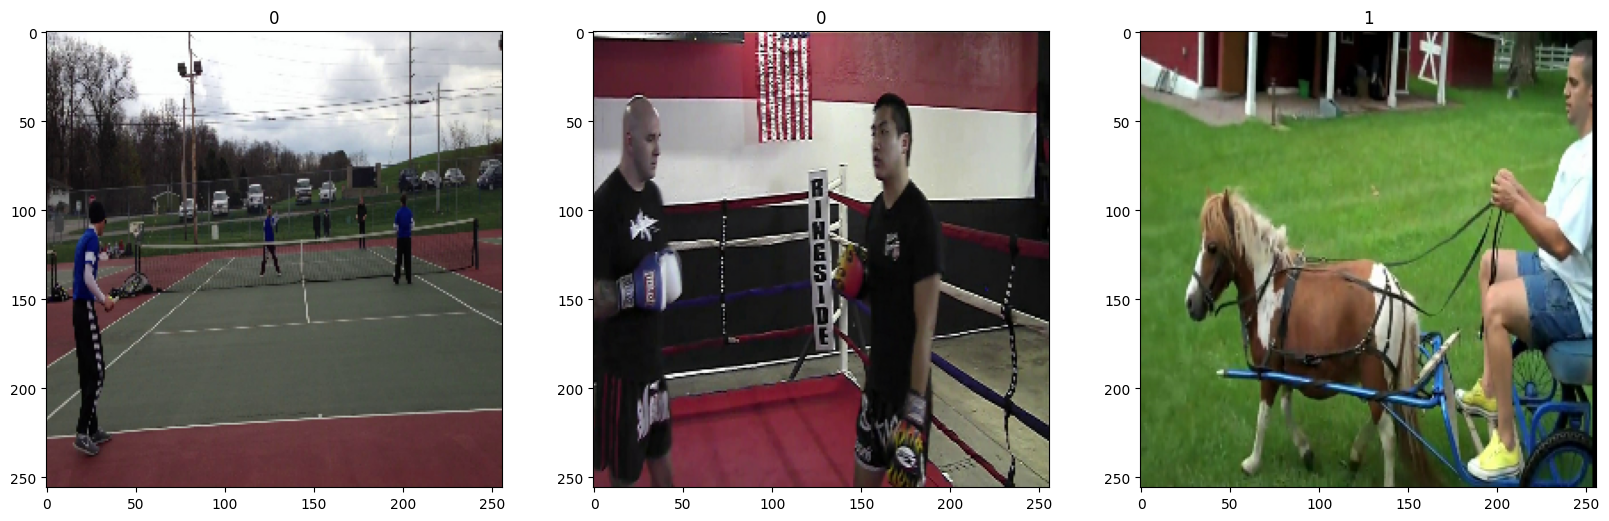

In [17]:
fig, ax = plt.subplots (ncols=3, figsize=(20,20))

for idx, img in enumerate (batch[0][10:13]): 
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Spliting the data into training and Validation data 

In [18]:
len(TRAINING_DATA) #training data contains 77 32 sized batches 

89

In [19]:
train_size = int(len(TRAINING_DATA)*0.8) #taking 80% as training 
val_size = int(len(TRAINING_DATA)*0.2) + 1  #taking 20% as validation 
print(train_size)
print(val_size)

71
18


In [20]:
train = TRAINING_DATA.take(train_size)
val = TRAINING_DATA.skip(train_size).take(val_size)

In [21]:
len(train)

71

In [22]:
len(val)

18

Making the Deep Learning Model

In [23]:
from tensorflow.keras.models import Sequential  #we will use a sequential model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #loading different layers for the model

from tensorflow.keras import regularizers #loading regularizers to overcome overfitting

In [24]:
model = Sequential()  #detailed explaination of the model is given in the documentation 

In [25]:
model.add(Conv2D(16, (3,3),1,activation = 'relu',input_shape=(256,256,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D())

model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Dropout(0.20))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [28]:
logdir = "D:\Intern\Data Science\Intern_Project\logs"  #creating the log directory

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Training the Data

In [30]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback]) #training the model for 20 epochs

Epoch 1/20
71/71 [==============================] - 162s 2s/step - loss: 1.6394 - accuracy: 0.6633 - val_loss: 0.9263 - val_accuracy: 0.6836
Epoch 2/20
71/71 [==============================] - 169s 2s/step - loss: 0.8467 - accuracy: 0.6853 - val_loss: 0.8033 - val_accuracy: 0.6923
Epoch 3/20
71/71 [==============================] - 172s 2s/step - loss: 0.7722 - accuracy: 0.6963 - val_loss: 0.7340 - val_accuracy: 0.7045
Epoch 4/20
71/71 [==============================] - 169s 2s/step - loss: 0.7239 - accuracy: 0.7205 - val_loss: 0.7416 - val_accuracy: 0.7010
Epoch 5/20
71/71 [==============================] - 173s 2s/step - loss: 0.7173 - accuracy: 0.7174 - val_loss: 0.6585 - val_accuracy: 0.7325
Epoch 6/20
71/71 [==============================] - 171s 2s/step - loss: 0.6958 - accuracy: 0.7179 - val_loss: 0.6562 - val_accuracy: 0.7517
Epoch 7/20
71/71 [==============================] - 177s 2s/step - loss: 0.6732 - accuracy: 0.7311 - val_loss: 0.6621 - val_accuracy: 0.7115
Epoch 8/20
71

Plotting the Losses Graph

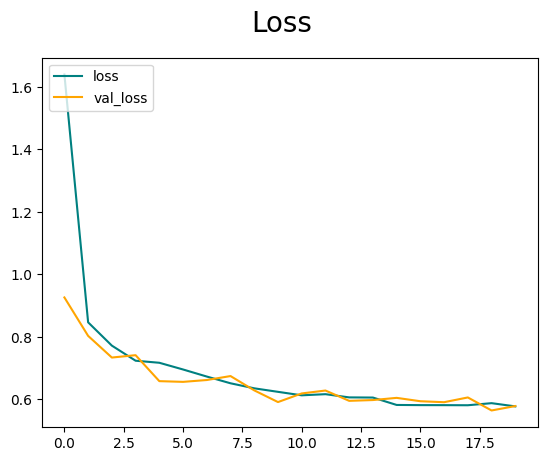

In [31]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)

plt.legend(loc="upper left")

plt.show()

In [32]:
test = "D:\Intern\Data Science\Intern_Project\Test"  #put the testing the data path here 

In [33]:
os.listdir(test)

['conditioning excercise', 'Sports']

Loading the Testing Data

In [34]:
TESTING_DATA = tf.keras.utils.image_dataset_from_directory(test)

Found 1027 files belonging to 2 classes.


In [35]:
test_data_iterator = TESTING_DATA.as_numpy_iterator() #Changing the images as numpy arrays

In [36]:
testing_batch = test_data_iterator.next() #doing it with all the batches 

In [37]:
testing_batch[0].shape  #(size of batch, hight in pixels, width in pixels, no of colour channels)

(32, 256, 256, 3)

In [38]:
testing_batch[1]  # randomized labels 

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0])

Scaling the Testing Data

In [39]:
TESTING_DATA = TESTING_DATA.map(lambda x,y:(x/255,y))   #dividing the hight and width by 255, such that it lies [0,1]

In [40]:
testing_scaled_iterator = TESTING_DATA.as_numpy_iterator()  #Changing the scaled images as numpy arrays

In [41]:
testing_batch = testing_scaled_iterator.next()  #doing it with all the batches 

In [42]:
len(TESTING_DATA)  # We have 33 batches, each of size 32

33

In [43]:
test = TESTING_DATA

In [44]:
from tensorflow.keras.metrics import Precision, BinaryAccuracy #importing different metrics to measure accuracy of our model

In [45]:
pre = Precision()

acc = BinaryAccuracy()

In [46]:
for batch in test.as_numpy_iterator():

    X, y = batch

    yhat = model.predict(X)  #for a given input our model is predicting the output, then it is compared to the actual label and the accuracy is calculated

    pre.update_state(y, yhat)

    acc.update_state(y, yhat)

1/1 [==============================] - 0s 419ms/step


In [47]:
print(f'Precision: {pre.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6953405141830444, Accuracy: 0.7779941558837891
